In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)

# load_data.py

In [3]:
if "df_raw" not in globals():
    df_raw = pd.read_csv("../data/raw/apple_health_export_2025-11-22.csv")

/var/folders/n5/vq6xltkj6nbfjvktp9d79y0h0000gn/T/ipykernel_15417/3583709988.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,9,10,13,14,16,19,22,27,28,29,30,31,33,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("../data/raw/apple_health_export_2025-11-22.csv")


In [4]:
df_raw.head()

,type,sourceName,value,unit,startDate,endDate,creationDate,appleStandHours,appleExerciseTimeGoal,FitzpatrickSkinType,...,path,BloodType,device,date,key,activeEnergyBurned,dateComponents,BiologicalSex,sum,time
0,MenstrualFlow,Cycle Tracking,HKCategoryValueVaginalBleedingUnspecified,NaN,2025-11-19 12:00:00 +0100,2025-11-19 12:00:00 +0100,2025-11-19 08:45:07 +0100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HeartRate,Yichen的Apple Watch,69,count/min,2025-11-19 10:10:23 +0100,2025-11-19 10:10:23 +0100,2025-11-19 10:13:52 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710e96fd0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HeartRate,Yichen的Apple Watch,66,count/min,2025-11-19 10:05:05 +0100,2025-11-19 10:05:05 +0100,2025-11-19 10:12:26 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710e96fd0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ActiveEnergyBurned,Yichen的Apple Watch,0.363,kcal,2025-11-19 10:02:39 +0100,2025-11-19 10:04:21 +0100,2025-11-19 10:05:13 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710ad6530>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HeartRate,Yichen的Apple Watch,68,count/min,2025-11-19 09:58:16 +0100,2025-11-19 09:58:16 +0100,2025-11-19 10:05:13 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710e96fd0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


# preprocessing_raw_data.py
fix dtypes
handle missing values
remove invalid rows
timestamp → date
rename columns

In [5]:
# check unique columns
df_raw["type"].unique()

array(['MenstrualFlow', 'HeartRate', 'ActiveEnergyBurned',
       'BasalEnergyBurned', 'StepCount', 'DistanceWalkingRunning',
       'PhysicalEffort', 'EnvironmentalAudioExposure', 'AppleStandTime',
       'HeartRateVariabilitySDNN', 'AppleStandHour', 'AppleExerciseTime',
       'WalkingStepLength', 'WalkingDoubleSupportPercentage',
       'WalkingSpeed', 'StairAscentSpeed', 'FlightsClimbed',
       'WalkingAsymmetryPercentage', 'StairDescentSpeed',
       'RespiratoryRate', 'SleepAnalysis', 'RestingHeartRate', 'VO2Max',
       'RunningPower', 'RunningSpeed', 'RunningVerticalOscillation',
       'RunningGroundContactTime', 'RunningStrideLength', nan,
       'WalkingHeartRateAverage', 'HeadphoneAudioExposure',
       'AudioExposureEvent', 'HeartRateRecoveryOneMinute', 'Fatigue',
       'SixMinuteWalkTestDistance', 'AppleWalkingSteadiness',
       'MindfulSession', 'MoodChanges', 'BreastPain', 'Diarrhea',
       'HKDataTypeSleepDurationGoal', 'AbdominalCramps', 'Headache',
       'Chills

## fix_dtpes_datetime()

In [6]:
# fix_dtpes_datetime()
df_raw["startDate"] = pd.to_datetime(df_raw["startDate"])
df_raw["endDate"] = pd.to_datetime(df_raw["endDate"])

## select_datasource_watch()

In [7]:
df_raw["sourceName"].unique()

array(['Cycle Tracking', 'Yichen的Apple\xa0Watch', 'Yichen’s Phone (2)',
       'Pillow', 'AutoSleep', nan, 'Health', 'Yichen的 iPad (2)', 'Sleep',
       'Zepp Life', 'Keep', '香山 Health', 'Clock'], dtype=object)

In [8]:
# select_datasource_watch()
df_raw = df_raw[df_raw["sourceName"].str.contains("Watch", na=False)]
df_raw.head()

,type,sourceName,value,unit,startDate,endDate,creationDate,appleStandHours,appleExerciseTimeGoal,FitzpatrickSkinType,...,path,BloodType,device,date,key,activeEnergyBurned,dateComponents,BiologicalSex,sum,time
1,HeartRate,Yichen的Apple Watch,69,count/min,2025-11-19 10:10:23+01:00,2025-11-19 10:10:23+01:00,2025-11-19 10:13:52 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710e96fd0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HeartRate,Yichen的Apple Watch,66,count/min,2025-11-19 10:05:05+01:00,2025-11-19 10:05:05+01:00,2025-11-19 10:12:26 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710e96fd0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ActiveEnergyBurned,Yichen的Apple Watch,0.363,kcal,2025-11-19 10:02:39+01:00,2025-11-19 10:04:21+01:00,2025-11-19 10:05:13 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710ad6530>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HeartRate,Yichen的Apple Watch,68,count/min,2025-11-19 09:58:16+01:00,2025-11-19 09:58:16+01:00,2025-11-19 10:05:13 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710e96fd0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,HeartRate,Yichen的Apple Watch,69,count/min,2025-11-19 09:55:06+01:00,2025-11-19 09:55:06+01:00,2025-11-19 09:59:38 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710e96fd0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


# preprocessing_sleep_data.py

## process_sleep_data()

In [9]:
df_sleep = df_raw[df_raw["type"] == "SleepAnalysis"]
df_sleep.head()

,type,sourceName,value,unit,startDate,endDate,creationDate,appleStandHours,appleExerciseTimeGoal,FitzpatrickSkinType,...,path,BloodType,device,date,key,activeEnergyBurned,dateComponents,BiologicalSex,sum,time
365,SleepAnalysis,Yichen的Apple Watch,HKCategoryValueSleepAnalysisInBed,NaN,2025-11-19 06:50:57+01:00,2025-11-19 07:02:27+01:00,2025-11-19 07:16:44 +0100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,SleepAnalysis,Yichen的Apple Watch,HKCategoryValueSleepAnalysisAsleepCore,NaN,2025-11-19 06:50:57+01:00,2025-11-19 07:02:27+01:00,2025-11-19 07:16:44 +0100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,SleepAnalysis,Yichen的Apple Watch,HKCategoryValueSleepAnalysisAwake,NaN,2025-11-19 06:42:57+01:00,2025-11-19 06:50:57+01:00,2025-11-19 07:16:44 +0100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384,SleepAnalysis,Yichen的Apple Watch,HKCategoryValueSleepAnalysisInBed,NaN,2025-11-19 06:28:57+01:00,2025-11-19 06:42:57+01:00,2025-11-19 07:16:44 +0100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385,SleepAnalysis,Yichen的Apple Watch,HKCategoryValueSleepAnalysisAsleepCore,NaN,2025-11-19 06:28:57+01:00,2025-11-19 06:42:57+01:00,2025-11-19 07:16:44 +0100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### select_sleep_data()

In [10]:
# select_sleep_data()
df_sleep = df_raw[df_raw["type"] == "SleepAnalysis"]
df_sleep = df_sleep[["value", "startDate", "endDate"]]

In [11]:
df_sleep.head()

,value,startDate,endDate
365,HKCategoryValueSleepAnalysisInBed,2025-11-19 06:50:57+01:00,2025-11-19 07:02:27+01:00
366,HKCategoryValueSleepAnalysisAsleepCore,2025-11-19 06:50:57+01:00,2025-11-19 07:02:27+01:00
372,HKCategoryValueSleepAnalysisAwake,2025-11-19 06:42:57+01:00,2025-11-19 06:50:57+01:00
384,HKCategoryValueSleepAnalysisInBed,2025-11-19 06:28:57+01:00,2025-11-19 06:42:57+01:00
385,HKCategoryValueSleepAnalysisAsleepCore,2025-11-19 06:28:57+01:00,2025-11-19 06:42:57+01:00


### get_sleep_day()
if sleep segment starts in the evening, count it for the next day

In [12]:
def get_sleep_day(start):
    # if sleep segment starts in the evening, count it for the next day
    if start.hour >= 18:
        return (start + pd.Timedelta(days=1)).date()
    else:
        return start.date()

In [13]:
df_sleep["sleep_day"] = df_sleep["startDate"].apply(get_sleep_day)

In [14]:
df_sleep.head()

,value,startDate,endDate,sleep_day
365,HKCategoryValueSleepAnalysisInBed,2025-11-19 06:50:57+01:00,2025-11-19 07:02:27+01:00,2025-11-19
366,HKCategoryValueSleepAnalysisAsleepCore,2025-11-19 06:50:57+01:00,2025-11-19 07:02:27+01:00,2025-11-19
372,HKCategoryValueSleepAnalysisAwake,2025-11-19 06:42:57+01:00,2025-11-19 06:50:57+01:00,2025-11-19
384,HKCategoryValueSleepAnalysisInBed,2025-11-19 06:28:57+01:00,2025-11-19 06:42:57+01:00,2025-11-19
385,HKCategoryValueSleepAnalysisAsleepCore,2025-11-19 06:28:57+01:00,2025-11-19 06:42:57+01:00,2025-11-19


###  select_time_20to12_as_sleep()

In [15]:
sleep_not_night = df_sleep[(df_sleep["startDate"].dt.hour < 20) & (df_sleep["startDate"].dt.hour > 12)]
print(sleep_not_night)

                                          value                 startDate  \
210277        HKCategoryValueSleepAnalysisAwake 2025-09-13 18:40:58+01:00   
210282        HKCategoryValueSleepAnalysisInBed 2025-09-13 18:39:28+01:00   
210283   HKCategoryValueSleepAnalysisAsleepCore 2025-09-13 18:39:28+01:00   
210284        HKCategoryValueSleepAnalysisAwake 2025-09-13 18:38:28+01:00   
210286   HKCategoryValueSleepAnalysisAsleepCore 2025-09-13 18:36:58+01:00   
210287        HKCategoryValueSleepAnalysisInBed 2025-09-13 18:36:58+01:00   
210290        HKCategoryValueSleepAnalysisAwake 2025-09-13 18:33:58+01:00   
210295   HKCategoryValueSleepAnalysisAsleepCore 2025-09-13 18:27:28+01:00   
210296        HKCategoryValueSleepAnalysisInBed 2025-09-13 18:27:28+01:00   
210297        HKCategoryValueSleepAnalysisAwake 2025-09-13 18:26:28+01:00   
210303        HKCategoryValueSleepAnalysisInBed 2025-09-13 18:17:28+01:00   
210304   HKCategoryValueSleepAnalysisAsleepCore 2025-09-13 18:17:28+01:00   

In [16]:
# select_time_20to12_as_sleep()
df_sleep = df_sleep[(df_sleep["startDate"].dt.hour > 20) | (df_sleep["startDate"].dt.hour < 12) ]

### compute_sleep_duraiton_each_stage()

In [17]:
# compute_sleep_duraiton_in_minu()
df_sleep["duration"] = (df_sleep["endDate"] - df_sleep["startDate"])#.dt.total_seconds()
df_sleep["duration_minute"] = df_sleep["duration"].dt.total_seconds() / 60
# df_sleep["duration_hour"] = df_sleep["duration"].dt.total_seconds() / 60 /60

In [18]:
df_sleep.head()

,value,startDate,endDate,sleep_day,duration,duration_minute
365,HKCategoryValueSleepAnalysisInBed,2025-11-19 06:50:57+01:00,2025-11-19 07:02:27+01:00,2025-11-19,0 days 00:11:30,11.5
366,HKCategoryValueSleepAnalysisAsleepCore,2025-11-19 06:50:57+01:00,2025-11-19 07:02:27+01:00,2025-11-19,0 days 00:11:30,11.5
372,HKCategoryValueSleepAnalysisAwake,2025-11-19 06:42:57+01:00,2025-11-19 06:50:57+01:00,2025-11-19,0 days 00:08:00,8.0
384,HKCategoryValueSleepAnalysisInBed,2025-11-19 06:28:57+01:00,2025-11-19 06:42:57+01:00,2025-11-19,0 days 00:14:00,14.0
385,HKCategoryValueSleepAnalysisAsleepCore,2025-11-19 06:28:57+01:00,2025-11-19 06:42:57+01:00,2025-11-19,0 days 00:14:00,14.0


### aggregate_daily_sleep_by_stage(df_sleep)
to do: describe these two steps

In [19]:
# aggregated_daily_sleep_by_stage()
sleep_grouped = df_sleep.groupby(["sleep_day", "value"])["duration_minute"].sum().reset_index()
sleep_grouped.head()

,sleep_day,value,duration_minute
0,2022-07-23,HKCategoryValueSleepAnalysisAsleepUnspecified,438.5
1,2022-07-24,HKCategoryValueSleepAnalysisAsleepUnspecified,453.0
2,2022-07-25,HKCategoryValueSleepAnalysisAsleepUnspecified,454.0
3,2022-07-26,HKCategoryValueSleepAnalysisAsleepUnspecified,442.5
4,2022-07-27,HKCategoryValueSleepAnalysisAsleepUnspecified,459.0


In [20]:
# aggregated_daily_sleep_by_stage()
sleep_agg = (sleep_grouped.pivot(
    index="sleep_day",
    columns="value",
    values="duration_minute"
)
             .fillna(0)
             .reset_index())

sleep_agg.columns.name = None

sleep_agg

,sleep_day,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,HKCategoryValueSleepAnalysisInBed
0,2022-07-23,0.0,0.0,0.0,438.5,0.0,0.0
1,2022-07-24,0.0,0.0,0.0,453.0,0.0,0.0
2,2022-07-25,0.0,0.0,0.0,454.0,0.0,0.0
3,2022-07-26,0.0,0.0,0.0,442.5,0.0,0.0
4,2022-07-27,0.0,0.0,0.0,459.0,0.0,0.0
5,2022-07-28,0.0,0.0,0.0,453.0,0.0,0.0
6,2022-07-29,0.0,0.0,0.0,438.0,0.0,0.0
7,2022-07-30,0.0,0.0,0.0,515.5,0.0,0.0
8,2022-07-31,0.0,0.0,0.0,428.5,0.0,0.0
9,2022-08-01,0.0,0.0,0.0,464.0,0.0,0.0


### rename_sleep_data_column(sleep_agg)

In [21]:
sleep_agg.columns = sleep_agg.columns.str.replace("HKCategoryValueSleepAnalysis", "", regex=False)

In [22]:
sleep_agg.columns

Index(['sleep_day', 'AsleepCore', 'AsleepDeep', 'AsleepREM',
       'AsleepUnspecified', 'Awake', 'InBed'],
      dtype='object')

In [23]:
sleep_agg = sleep_agg.rename(columns ={
    'AsleepCore': 'sleepCore',
    'AsleepDeep': 'sleepDeep',
    'AsleepREM': 'sleepREM',
    'AsleepUnspecified': 'sleepUnspecified',
    'Awake': 'awake',
    'InBed': 'inBed'
})

### completeness_check()

In [24]:
 df_incomplete = sleep_agg[(sleep_agg["sleepCore"] == 0) &
                        (sleep_agg["sleepDeep"] == 0) &
                        (sleep_agg["sleepREM"] == 0)]
 df_incomplete

,sleep_day,sleepCore,sleepDeep,sleepREM,sleepUnspecified,awake,inBed
0,2022-07-23,0.0,0.0,0.0,438.5,0.0,0.0
1,2022-07-24,0.0,0.0,0.0,453.0,0.0,0.0
2,2022-07-25,0.0,0.0,0.0,454.0,0.0,0.0
3,2022-07-26,0.0,0.0,0.0,442.5,0.0,0.0
4,2022-07-27,0.0,0.0,0.0,459.0,0.0,0.0
5,2022-07-28,0.0,0.0,0.0,453.0,0.0,0.0
6,2022-07-29,0.0,0.0,0.0,438.0,0.0,0.0
7,2022-07-30,0.0,0.0,0.0,515.5,0.0,0.0
8,2022-07-31,0.0,0.0,0.0,428.5,0.0,0.0
9,2022-08-01,0.0,0.0,0.0,464.0,0.0,0.0


In [25]:
df_sleep0 = sleep_agg[
    (sleep_agg["sleepCore"] != 0) &
    (sleep_agg["sleepDeep"] != 0) &
    (sleep_agg["sleepREM"] != 0)
]

### na, null checken

In [26]:
df_sleep0.isnull().sum()
df_sleep0.isna().sum()

sleep_day           0
sleepCore           0
sleepDeep           0
sleepREM            0
sleepUnspecified    0
awake               0
inBed               0
dtype: int64

### Duplicates

In [27]:
df_sleep0.duplicated().sum()

np.int64(0)

### clean data with <4h sleep sum

In [28]:
df_sleep0["sleep_sum"] = df_sleep0["sleepCore"] + df_sleep0["sleepDeep"] + df_sleep0["sleepREM"] + df_sleep0['sleepUnspecified'] + df_sleep0["awake"]

/var/folders/n5/vq6xltkj6nbfjvktp9d79y0h0000gn/T/ipykernel_15417/2275549302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sleep0["sleep_sum"] = df_sleep0["sleepCore"] + df_sleep0["sleepDeep"] + df_sleep0["sleepREM"] + df_sleep0['sleepUnspecified'] + df_sleep0["awake"]


In [29]:
sleep_less_than_4h = df_sleep0[df_sleep0["sleep_sum"] < 240]
sleep_less_than_4h

,sleep_day,sleepCore,sleepDeep,sleepREM,sleepUnspecified,awake,inBed,sleep_sum
173,2023-04-01,157.0,26.0,46.5,0.0,9.5,229.5,239.0
215,2023-06-09,116.5,8.0,39.5,0.0,5.0,136.0,169.0
326,2024-01-18,88.0,12.5,24.0,0.0,6.0,116.5,130.5
770,2025-09-03,34.5,8.5,10.5,0.0,5.0,16.5,58.5
772,2025-09-14,131.0,8.0,20.0,0.0,11.5,116.5,170.5


In [30]:
df_sleep1 = df_sleep0[df_sleep0["sleep_sum"] >= 240]

### calculate_sleep_index

In [31]:
df_sleep1["sleep_efficiency"] = (df_sleep1["sleep_sum"] - df_sleep1["awake"]) / df_sleep1["sleep_sum"]

/var/folders/n5/vq6xltkj6nbfjvktp9d79y0h0000gn/T/ipykernel_15417/3913649325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sleep1["sleep_efficiency"] = (df_sleep1["sleep_sum"] - df_sleep1["awake"]) / df_sleep1["sleep_sum"]


In [32]:
df_sleep1["deep_rem_ratio"] = (df_sleep1["sleepDeep"] + df_sleep1["sleepREM"]) / (df_sleep1["sleepCore"] + df_sleep1["sleepDeep"] + df_sleep1["sleepREM"])

/var/folders/n5/vq6xltkj6nbfjvktp9d79y0h0000gn/T/ipykernel_15417/2886750185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sleep1["deep_rem_ratio"] = (df_sleep1["sleepDeep"] + df_sleep1["sleepREM"]) / (df_sleep1["sleepCore"] + df_sleep1["sleepDeep"] + df_sleep1["sleepREM"])


In [33]:
# deep_rem_score
# 20–50% reflects realistic wearable sleep distributions
# Below 20% → insufficient restorative sleep
# Above 50% → often rebound, short sleep, or artifact

low, high = 0.20, 0.50

df_sleep1["deep_rem_score"] = (
    (df_sleep1["deep_rem_ratio"] - low) / (high - low)
).clip(0, 1)

/var/folders/n5/vq6xltkj6nbfjvktp9d79y0h0000gn/T/ipykernel_15417/4115427117.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sleep1["deep_rem_score"] = (


In [34]:
# SleepQuality=100×(0.6⋅sleep_efficiency+0.4⋅deep_rem_ratio)
df_sleep1["sleep_quality"] = 100 * (
    0.6 * df_sleep1["sleep_efficiency"]
    + 0.4 * df_sleep1["deep_rem_score"]
)

/var/folders/n5/vq6xltkj6nbfjvktp9d79y0h0000gn/T/ipykernel_15417/3777493150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sleep1["sleep_quality"] = 100 * (


In [35]:
df_sleep1

,sleep_day,sleepCore,sleepDeep,sleepREM,sleepUnspecified,awake,inBed,sleep_sum,sleep_efficiency,deep_rem_ratio,deep_rem_score,sleep_quality
60,2022-10-04,222.0,73.0,101.5,0.0,1.5,0.0,398.0,0.996231,0.440101,0.800336,91.787320
61,2022-10-05,291.0,53.5,109.5,0.0,3.0,0.0,457.0,0.993435,0.359031,0.530103,80.810239
62,2022-10-06,226.5,76.0,108.0,0.0,10.0,0.0,420.5,0.976219,0.448234,0.827446,91.670975
63,2022-10-08,403.0,44.5,147.5,0.0,26.5,0.0,621.5,0.957361,0.322689,0.408964,73.800217
64,2022-10-09,371.5,36.5,126.5,0.0,7.0,0.0,541.5,0.987073,0.304958,0.349860,73.218764
65,2022-10-10,341.0,35.0,137.5,0.0,5.5,0.0,519.0,0.989403,0.335930,0.453100,77.488148
66,2022-10-11,327.5,47.0,101.5,0.0,4.5,0.0,480.5,0.990635,0.311975,0.373249,74.368057
67,2022-10-12,375.5,61.5,139.5,0.0,2.5,0.0,579.0,0.995682,0.348656,0.495519,79.561690
68,2022-10-13,306.0,42.0,109.5,0.0,3.5,0.0,461.0,0.992408,0.331148,0.437158,77.030807
69,2022-10-14,335.5,60.5,118.5,0.0,14.5,0.0,529.0,0.972590,0.347911,0.493035,78.076800


### plot and check

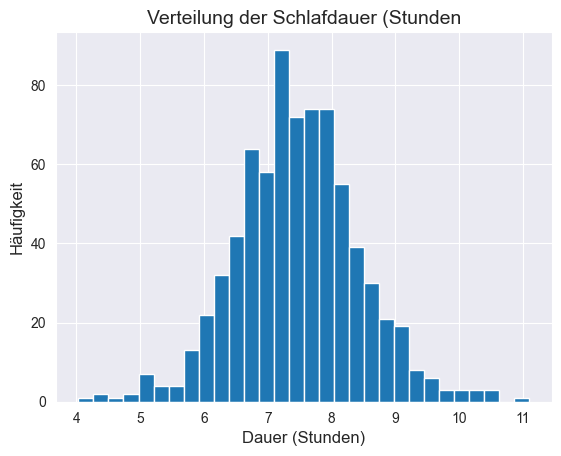

In [36]:
plt.hist(df_sleep1["sleep_sum"] /60, bins=30)
plt.title("Verteilung der Schlafdauer (Stunden)", fontsize=14)
plt.xlabel("Dauer (Stunden)", fontsize=12)
plt.ylabel("Häufigkeit", fontsize=12)
plt.show()

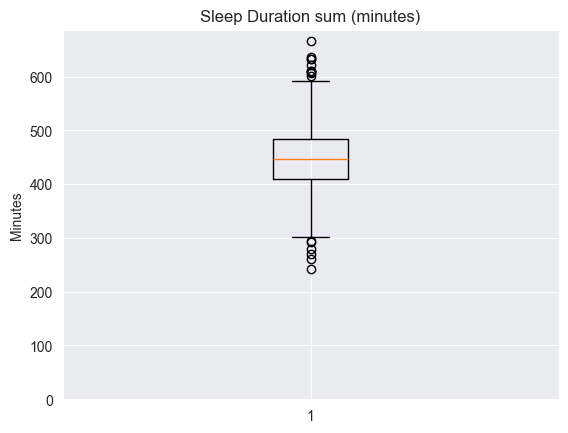

In [37]:
# Identify Outliers with box-plot
plt.boxplot(df_sleep1["sleep_sum"])
plt.title("Sleep Duration sum (minutes)")
plt.ylabel("Minutes")
plt.ylim(bottom=0)
plt.show()

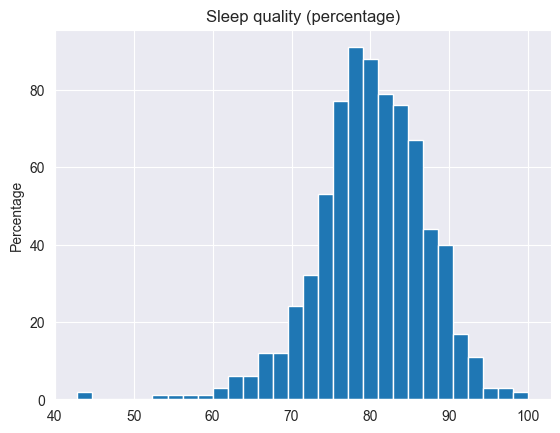

In [38]:
# Identify Outliers with box-plot
plt.hist(df_sleep1["sleep_quality"],bins=30)
plt.title("Sleep quality (percentage)")
plt.ylabel("Percentage")
plt.ylim(bottom=0)
plt.show()

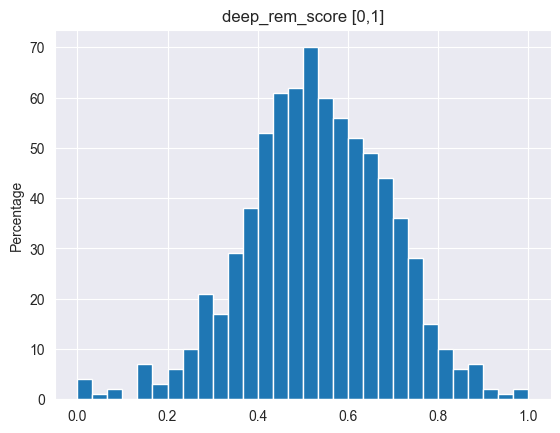

In [39]:
# Identify Outliers with box-plot
plt.hist(df_sleep1["deep_rem_score"], bins=30)
plt.title("deep_rem_score [0,1]")
plt.ylabel("Percentage")
plt.ylim(bottom=0)
plt.show()

# preprocessing_HRV_data.py

### select_HRV_data()

In [40]:
# select_hrv_data()
df_hrv = df_raw[df_raw["type"] == "HeartRateVariabilitySDNN"]
df_hrv = df_hrv[["value", "startDate", "endDate"]]
df_hrv.head()

,value,startDate,endDate
38,21.1657,2025-11-19 09:09:35+01:00,2025-11-19 09:10:34+01:00
371,55.3567,2025-11-19 06:43:58+01:00,2025-11-19 06:44:58+01:00
449,110.33,2025-11-19 04:42:44+01:00,2025-11-19 04:43:43+01:00
519,30.4737,2025-11-19 02:42:44+01:00,2025-11-19 02:43:43+01:00
584,36.0952,2025-11-19 00:55:38+01:00,2025-11-19 00:56:38+01:00


### get_hrv_day()

In [41]:
def get_hrv_day(end):
        return end.date()

In [42]:
df_hrv["hrv_day"] = df_hrv["endDate"].apply(get_hrv_day)

In [43]:
df_hrv.head()

,value,startDate,endDate,hrv_day
38,21.1657,2025-11-19 09:09:35+01:00,2025-11-19 09:10:34+01:00,2025-11-19
371,55.3567,2025-11-19 06:43:58+01:00,2025-11-19 06:44:58+01:00,2025-11-19
449,110.33,2025-11-19 04:42:44+01:00,2025-11-19 04:43:43+01:00,2025-11-19
519,30.4737,2025-11-19 02:42:44+01:00,2025-11-19 02:43:43+01:00,2025-11-19
584,36.0952,2025-11-19 00:55:38+01:00,2025-11-19 00:56:38+01:00,2025-11-19


### fix_dtpes_hrv_value()

In [44]:
df_hrv["value"] = pd.to_numeric(df_hrv["value"], errors="coerce")

In [45]:
df_hrv.head()

,value,startDate,endDate,hrv_day
38,21.1657,2025-11-19 09:09:35+01:00,2025-11-19 09:10:34+01:00,2025-11-19
371,55.3567,2025-11-19 06:43:58+01:00,2025-11-19 06:44:58+01:00,2025-11-19
449,110.3300,2025-11-19 04:42:44+01:00,2025-11-19 04:43:43+01:00,2025-11-19
519,30.4737,2025-11-19 02:42:44+01:00,2025-11-19 02:43:43+01:00,2025-11-19
584,36.0952,2025-11-19 00:55:38+01:00,2025-11-19 00:56:38+01:00,2025-11-19


### aggregate_daily_mean_hrv()

In [46]:
hrv_agg = df_hrv.groupby(["hrv_day"])["value"].mean().reset_index()
hrv_agg.head()

,hrv_day,value
0,2022-07-22,31.076133
1,2022-07-23,39.513417
2,2022-07-24,44.292517
3,2022-07-25,34.085320
4,2022-07-26,58.217429


In [47]:
df_hrv = hrv_agg.rename(columns={"value": "mean_hrv"})

In [48]:
df_hrv

,hrv_day,mean_hrv
0,2022-07-22,31.076133
1,2022-07-23,39.513417
2,2022-07-24,44.292517
3,2022-07-25,34.085320
4,2022-07-26,58.217429
5,2022-07-27,27.340533
6,2022-07-28,34.528467
7,2022-07-29,42.778983
8,2022-07-30,47.258400
9,2022-07-31,41.408817


### plot and check

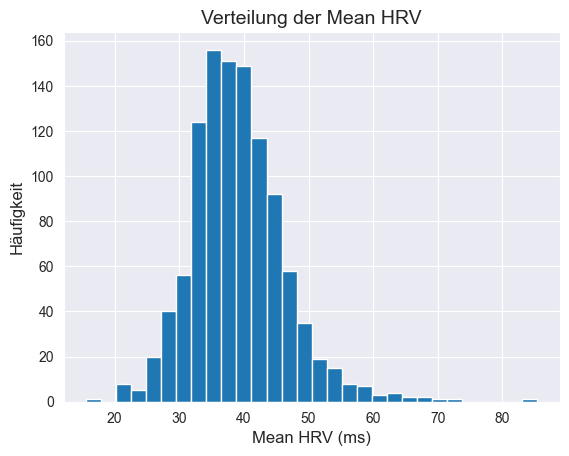

In [49]:
plt.hist(df_hrv["mean_hrv"], bins=30)
plt.title("Verteilung der Mean HRV", fontsize=14)
plt.xlabel("Mean HRV (ms)", fontsize=12)
plt.ylabel("Häufigkeit", fontsize=12)
plt.show()

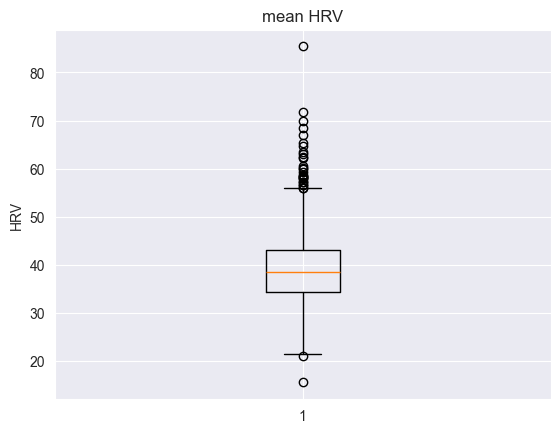

In [50]:
# Identify Outliers with box-plot
plt.boxplot(df_hrv["mean_hrv"])
plt.title("mean HRV")
plt.ylabel("HRV")
plt.show()

# StepCount

In [51]:
df_stepCount = df_raw[df_raw["type"] == "StepCount"]
df_stepCount.head()

,type,sourceName,value,unit,startDate,endDate,creationDate,appleStandHours,appleExerciseTimeGoal,FitzpatrickSkinType,...,path,BloodType,device,date,key,activeEnergyBurned,dateComponents,BiologicalSex,sum,time
11,StepCount,Yichen的Apple Watch,44,count,2025-11-19 09:50:40+01:00,2025-11-19 09:51:26+01:00,2025-11-19 10:05:13 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710b1f6b0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,StepCount,Yichen的Apple Watch,9,count,2025-11-19 09:29:09+01:00,2025-11-19 09:29:12+01:00,2025-11-19 09:42:35 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710b1f6b0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,StepCount,Yichen的Apple Watch,2,count,2025-11-19 09:10:49+01:00,2025-11-19 09:10:51+01:00,2025-11-19 09:30:02 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710b1f6b0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,StepCount,Yichen的Apple Watch,11,count,2025-11-19 08:59:20+01:00,2025-11-19 08:59:23+01:00,2025-11-19 09:10:24 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710b1f6b0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,StepCount,Yichen的Apple Watch,18,count,2025-11-19 08:48:19+01:00,2025-11-19 08:48:25+01:00,2025-11-19 09:09:15 +0100,NaN,NaN,NaN,...,NaN,NaN,"<<HKDevice: 0x710b1f6b0>, name:Apple Watch, ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
df_final = pd.merge(df_sleep1, df_hrv, left_on="sleep_day", right_on="hrv_day", how="left")

In [112]:
df_final = df_final.sort_values(by=["sleep_day"])

In [52]:
df_final

In [53]:
df_final.to_csv("../data/processed/data_final.csv", index=False)